In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import skew, kurtosis
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format


In [22]:
#CLEANING
df = pd.read_csv("Alzheimers Mice Data.csv")
df['AD_Status'] = df['AD_Status'].map({1: 'Transgenic', 2: 'Wild'})
df['Treatment'] = df['Treatment'].map({1: 'Drug 1', 2: 'Drug 2', 3: 'Drug 3', 4: 'Drug 4'})
df.head()

,AD_Status,Treatment,Training,Memory
0,Transgenic,Drug 1,12,10
1,Transgenic,Drug 1,15,12
2,Transgenic,Drug 1,13,13
3,Transgenic,Drug 1,12,10
4,Transgenic,Drug 1,14,13


#### Dataset
Mice are used in an experiment to test drugs that may prevent Alzheimer’s disease. Half the mice are transgenic – have been genetically modified to have Alzheimer’s disease. The other half of the mice are “wild type” – they have not been modified in any way, and are considered free of Alzheimer’s disease. The mice are assigned to treatment conditions and given one of four drugs, then tested on memory using a maze. The number of errors made in the maze is recorded for the Training Day and the Memory Day.

#### Hypotheses
$H_0$: There is no significant interaction effect on training day errors between drug treatments and AD status. \$H_1$: There is a significant interaction effect on training day errors between drug treatments and AD status
.
#### Assumptions
**Assumption 1**: You have one dependent variable that is measured at the continuous level. \
Remark: The dependent variable *training day errors* is measured at the continuous level.

**Assumption 2**: You have two independent variables where each independent variable
consists of two or more categorical, independent groups \
Remark: The independent variables, *treatment* an *AD Status*, are categorical variables. *Treatment* has four independent groups (four different drugs) and *AD status* has two independent groups  transgenic and wild). 

**Assumption 3**: You should have independence of observations. \
Remark: Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the groups themselves.

**Assumption 4**: There should be no significant outliers in any cell of the design.


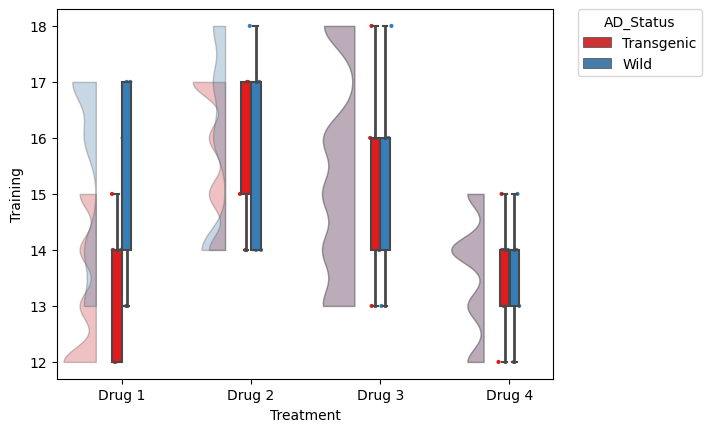

In [23]:
pt.RainCloud(data=df, x='Treatment', y='Training', hue='AD_Status',
             width_viol=0.5, alpha=0.3, palette='Set1', dodge=True)

plt.show()


Remark: By visual inspection of the plots, there are no significant outliers in any group.

**Assumption 5**: The distribution of the dependent variable (residuals) should be 
approximately normally distributed in every cell of the design.

In [24]:

df_grouped = df.groupby(['AD_Status', 'Treatment'])['Training']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (status, treatment), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(status, treatment)] = (stat, p_value)

shapiro_df = pd.DataFrame(results).transpose().rename(columns={0:'Shapiro', 1:'p-value'})
table_df = pd.concat([desc,skew_stderror, kurtosis, kurt_stderror, shapiro_df], axis=1)
display(HTML("""<h5>Descriptive Statistics</h5>"""))
display(table_df.transpose())


Transgenic                        Wild                \
                           Drug 1 Drug 2 Drug 3 Drug 4 Drug 1 Drug 2 Drug 3   
Valid                       5.000  5.000  5.000  5.000  5.000  5.000  5.000   
Mean                       13.200 15.800 15.200 13.600 15.400 15.800 15.200   
SD                          1.304  1.304  1.924  1.140  1.817  1.789  1.924   
Skewness                    0.541 -0.541  0.590 -0.405 -0.567  0.052  0.590   
Std. Error of Skewness      0.913  0.913  0.913  0.913  0.913  0.913  0.913   
Kurtosis                   -1.488 -1.488 -0.022 -0.178 -2.231 -2.324 -0.022   
Std. Error of Kurtosis      2.000  2.000  2.000  2.000  2.000  2.000  2.000   
Shapiro                     0.902  0.902  0.979  0.961  0.867  0.894  0.979   
p-value                     0.421  0.421  0.928  0.814  0.254  0.377  0.928   

                               
                       Drug 4  
Valid                   5.000  
Mean                   13.600  
SD                      1.140  
Skewness               -0.405  
Std. Error of Skewness  0.913  
Kurtosis               -0.178  
Std. Error of Kurtosis  2.000  
Shapiro                 0.961  
p-value                 0.814

Remark: As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the design.

**Assumption 6**: The variance of the dependent variable (residuals) should be equal in
every cell of the design

In [25]:
groups = []
for treatment in df['Treatment'].unique():
    for status in df['AD_Status'].unique():
        group_data = df[(df['Treatment'] == treatment) & (df['AD_Status'] == status)]['Training']
        groups.append(group_data)

stat_levene, p_levene = levene(*groups)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [len(df['Treatment'].unique()) * len(df['AD_Status'].unique()) - 1],
    'df2': [len(df) - len(df['Treatment'].unique()) * len(df['AD_Status'].unique())],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

display(HTML("""<h5>Test for Equality of Variances (Levene\'s Test)</h5>"""), levene_df)


,F,df1,df2,p
0,0.435,7,32,0.873


Remark: As assessed by Levene's Test for equality of variances, the variances for each combination of the dependent variables are equal (p>0.05).

#### Computation

In [26]:
welch_model = ols('Training ~ Treatment', data=df).fit()
welch_results = anova_lm(welch_model, typ=2).replace(np.nan, '')

display(HTML("""<h5>Welch's ANOVA</h5>"""), welch_results)

,sum_sq,df,F,PR(>F)
Treatment,28.275,3.000,3.700,0.020
Residual,91.700,36.000,,


Remark: Since p < 0.05, then there is a significant difference in the Traininf day errors for each Treatment group.

In [27]:
welch_model = ols('Training ~ AD_Status', data=df).fit()
welch_results = anova_lm(welch_model, typ=2).replace(np.nan, '')

display(HTML("""<h5>Welch's ANOVA</h5>"""), welch_results)

,sum_sq,df,F,PR(>F)
AD_Status,3.025,1.000,0.983,0.328
Residual,116.950,38.000,,


In [39]:
anova =pg.anova(dv='Training', between = ['AD_Status', 'Treatment'], data=df)
anova = anova.replace(np.nan, '')
display(HTML("""<h5>Two-Way ANOVA</h5>"""), anova.style.hide(axis="index"))

Source,SS,DF,MS,F,p-unc,np2
AD_Status,3.025000,1,3.025000,1.216080,0.278356,0.036611
Treatment,28.275000,3,9.425000,3.788945,0.019678,0.262109
AD_Status * Treatment,9.075000,3,3.025000,1.216080,0.319771,0.102340
Residual,79.600000,32,2.487500,,,


Remark: The results indicate that Treatment, F(3,32) = 3.789, p =0.020, $\eta^2_p$= 0.262, has a significant effect on Training Errors. This indicates that the number of Training Day errors differs significantly for the four Treatment groups. There was no significant main effect of AD_Status, F(1,32) = 1.216, p =0.278,  $\eta^2_p$ = 0.037 and no significant interaction between AD_Status and Treatment, F(3,32) = 1.216, p = 0.320,  $\eta^2_p$ = 0.102. Since there is no significant interaction, a main effects analysis for Treatment will be conducted.

In [48]:
results = {}

model = ols('Training ~ C(Treatment)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
    
f_val = anova_table.loc['C(Treatment)', 'F']
p_val = anova_table.loc['C(Treatment)', 'PR(>F)']
    
decision = p_val < 0.025
results[status] = {'Sum of Squares': anova_table.loc['C(Treatment)', 'sum_sq'],
                   'df': int(anova_table.loc['C(Treatment)', 'df']),
                   'Mean Square': anova_table.loc['C(Treatment)', 'sum_sq'] / anova_table.loc['C(Treatment)', 'df'],
                   'F': f_val,
                   'p': p_val,
                   'Reject': decision
                   }

results_df = pd.DataFrame(results).transpose()

display(HTML("""<h5>Main Effect - Treatment</h5>"""), results_df.style.hide(axis="index"))

Sum of Squares,df,Mean Square,F,p,Reject
28.275000,3,9.425000,3.700109,0.020296,True


Remark: A main effects analysis was performed to assess the effect of Treatment on Training Day errors regardless of AD Status. This analysis revealed that Treatment, F(3) = 3.700, p = 0.020, has a statistically significant effect on Training Day errors (p <0.025).


In [49]:
tukey = pairwise_tukeyhsd(df['Training'], df['Treatment'], alpha=0.05)
tukey_results = tukey.summary().data[1:]
tukey_df = pd.DataFrame(tukey_results, columns=['group1', 'group2', 'Mean Difference', 'p', 'Lower', 'Upper', 'Reject'])

display(HTML("""<h5>Post Hoc Comparisons - Treatment</h5>"""),tukey_df)

,group1,group2,Mean Difference,p,Lower,Upper,Reject
0,Drug 1,Drug 2,1.500,0.172,-0.422,3.422,False
1,Drug 1,Drug 3,0.900,0.593,-1.022,2.822,False
2,Drug 1,Drug 4,-0.700,0.761,-2.622,1.222,False
3,Drug 2,Drug 3,-0.600,0.835,-2.522,1.322,False
4,Drug 2,Drug 4,-2.200,0.020,-4.122,-0.278,True
5,Drug 3,Drug 4,-1.600,0.131,-3.522,0.322,False


Remark: Tukey's HSD revealed a significant difference between Treatment group 1 and group 2 (M = -2.20, p = 0.020), which indicates that the Training day errors differed between these groups while the rest of the pairwise comparisons were not statistically significant (p>0.05).

#### Report 
A two-way ANOVA was conducted to determine if there is a significant interaction effect on training day errors between drug treatments and AD status. The results revealed that there was no  statistically significant interaction between the effects of Treatment and AD Status F(3,32) = 1.216, p = 0.320,  $\eta^2_p$ = 0.102. The main effect analysis revelead that Treatment did have a statistically significant effect on Training Day errors (p = 0.02).
